# Fixed-Point DSP for Data Scientists

```
Copyright (c) 2021 Arm Limited. All rights reserved.

SPDX-License-Identifier: Apache-2.0
```

**Authors**: [Henri Woodcock](https://twitter.com/henriwoodcock), [Sandeep Mistry](https://twitter.com/sandeepmistry) on behalf of the [Arm Software Developer's Team](https://developer.arm.com)


## Introduction

When Machine Learning (ML) is applied in audio systems, the input audio signal is typically transformed into a 2D "image" using Digital Signal Processing (DSP) techniques, so that computer vision techiques can be used to classify the audio. Real world examples of this include [audio or speech recognition](https://www.tensorflow.org/tutorials/audio/simple_audio), and keyword spotting.

<br/>

This guide will introduce you to the DSP techniques used in these systems, using [Python](https://www.python.org) and [NumPy](https://numpy.org) code examples. Once you are familar with these DSP techiques, we will go through how to use [Arm's CMSIS-DSP library](https://arm-software.github.io/CMSIS_5/DSP/html/index.html) in Python to perform the same operations using fixed-point math.

<br/>

Finally we will demonstrate how to create an equivalent pipeline in C so that it can be deployed to an [Arm Cortex-M](https://developer.arm.com/ip-products/processors/cortex-m) based microcontroller (MCU).  **Using fixed-point math on Arm Cortex-M based systems can drastically reduce memory usage while improving run-time performance!**

## Audio Spectrograms

Throughout this notebook we will be developing an _audio spectrogram_ pipeline in both NumPy and CMSIS-DSP. This is a common preprocessing pipeline used with audio data. The raw audio samples are converted into a visual representation of the audio signal which shows frequency changes over time. It is most often represented as a 2D image.

For a more in-depth explanation of spectrograms, you can take a look at the TensorFlow [tutorial](https://www.tensorflow.org/tutorials/audio/simple_audio#spectrogram) on audio recognition.

To convert an audio signal into the frequency domain, a Fast Fourier Transform (FFT) is used. This converts an audio signal represented by amplitude over time to the frequency domain, represented amplitude by over frequencies. However, when an FFT is performed on the entire audio signal, you will lose the time information for that audio signal, to counteract this we break the audio down into separate segments.


### Spectrogram Steps

Creating a spectrogram can be broken down into the following steps:

1. An audio signal is broken down into shorter segments called "windows". This means when we later apply the FFT, we still keep some time information, because we know at what point in time each window occured. When splitting an audio signal into windows, it is common to have some overlap between windows to help keep the output more continuous. 

2. A _windowing function_ is then applied to each window. Breaking our signal into windows that overlap will leave us with discontinuities in the audio signal which will not accurately represent the real-world audio signal. To reduce this impact, the windowing function will smooth the edges of each window's amplitude by multiplying the window by a smooth symmetric curve between 0 and 1.

3. Each window is then converted into the frequency domain with an FFT. Because the FFT produces complex outputs, the _absolute value_ is taken of this output to keep the amplitude information but remove the complex numbers.

4. Finally a 2D array called the spectrogram is created of size (number of windows, FFT bins).

<br>

We've selected some example audio inputs along side their audio spectrogram representations for you below:

![spectrogram gif](./images/wave_and_spectrogram_med_res.gif)


## Audio Spectrograms in Python
Now that you have an overview of what an audio spectrogram is, we'll go through how to create one using Python and Numpy from a pre-recorded wave file.

### Install Python modules

You'll need to install the [NumPy](https://numpy.org), [Matplotlib](https://matplotlib.org), [SciPy](https://www.scipy.org) and [requests](https://requests.readthedocs.io) Python modules using `pip` :

In [1]:
!pip install numpy scipy matplotlib requests

     |████████████████████████████████| 16.9 MB 8.1 MB/s eta 0:00:01
     |████████████████████████████████| 32.1 MB 8.2 MB/s eta 0:00:01
  Using cached matplotlib-3.4.2-cp39-cp39-macosx_10_9_x86_64.whl (7.2 MB)
  Using cached Pillow-8.2.0-cp39-cp39-macosx_10_10_x86_64.whl (2.8 MB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
  Using cached kiwisolver-1.3.1-cp39-cp39-macosx_10_9_x86_64.whl (61 kB)
  Using cached idna-2.10-py2.py3-none-any.whl (58 kB)
  Attempting uninstall: idna
    Found existing installation: idna 3.2
    Uninstalling idna-3.2:
      Successfully uninstalled idna-3.2
You should consider upgrading via the '/Users/sanmis01/Developer/git/fixed-point-dsp-for-data-scientists/.env/bin/python3 -m pip install --upgrade pip' command.


### Download sample audio file

We'll be using a "door knocking" `.wav` file from the ["ESC-50: Dataset for Environmental Sound Classification" GitHub repo](https://github.com/karolpiczak/ESC-50) as the input signal for the DSP pipeline in the notebook. You can download the `.wav` file from GitHub using the `requests` library from Python:

In [2]:
import requests

wave_file = "1-103995-A-30.wav"
response = requests.get(f"https://github.com/karolpiczak/ESC-50/raw/master/audio/{wave_file}")

with open(wave_file, "wb") as f:
    f.write(response.content)

### Read data from the sample audio file

SciPy's [`scipy.io.wavfile.read(...)`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.read.html) API can now be used to read the audio samples from the `.wav` file.

The `.wav` file has a sampling rate of 44.1 kHz, which means each 1 second of audio is represented by 44,100 samples. We will also use SciPy's [`scipy.signal.resample(...)`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html) API to lower the sampling rate of the audio data from 44.1 kHz to 16 kHz to reduce the number of samples used in the analysis.

In [3]:
import numpy as np
from scipy.io import wavfile
from scipy import signal

def read_wave_file(file, sample_rate):
    # read sample rate and data from wave file
    original_sample_rate, orginal_audio_data = wavfile.read(file)

    # normalize input to floating-point value, if needed
    if orginal_audio_data.dtype is np.float32:
        audio_data_float32 = orginal_audio_data
    else:
        audio_data_float32 = orginal_audio_data / np.iinfo(orginal_audio_data.dtype).max

    # downsample to desired sample rate
    audio_data = signal.resample(audio_data_float32, (len(audio_data_float32) // original_sample_rate) * sample_rate)
    
    return audio_data

audio_sample_rate = 16000

audio_samples = read_wave_file(wave_file, audio_sample_rate)

print(f"Successfully read {len(audio_samples)} samples from '{wave_file} with sample rate of {audio_sample_rate}")

Successfully read 80000 samples from '1-103995-A-30.wav with sample rate of 16000


Now that we have the audio samples read from the `.wav` file, let's plot the audio signal over time using Matplotlib:

In [4]:
# switch the default matplotlib style to seaborn-whitegrid for
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use("seaborn-whitegrid")

mpl.rcParams['axes.prop_cycle'] = plt.cycler(color=[
    (  0 / 255, 145 / 255, 189 / 255), # blue
    (149 / 255, 214 / 255,   0 / 255), # green
    (255 / 255, 107 / 255,   0 / 255), # orange
    
    
    (255 / 255, 199 / 255,   0 / 255), # yellow
    (  0 / 255, 193 / 255, 222 / 255), # light blue
    (  0 / 255,  43 / 255,  73 / 255), # dark blue
    ( 51 / 255,  62 / 255,  72 / 255), # dark grey
    (125 / 255, 134 / 255, 140 / 255), # grey
    (229 / 255, 236 / 255, 235 / 255), # light gray
])

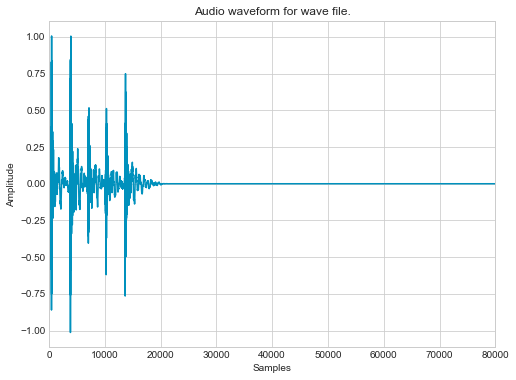

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))

plt.title("Audio waveform for wave file.")
plt.plot(audio_samples)
plt.xlabel("Samples")
plt.xlim(0, len(audio_samples))
plt.ylabel("Amplitude")
plt.show()

We can also listen to the downsampled audio samples from the `.wav` file:

In [6]:
from IPython import display

display.display(display.Audio(audio_samples, rate=audio_sample_rate))

Based on the graph of the entire audio signal, and playing the sound, we know there is about 1 second of sound at the start followed by silence. Let's zoom in and only plot the first 1 second of the audio signal over time using Matplotlib to take a closer look:

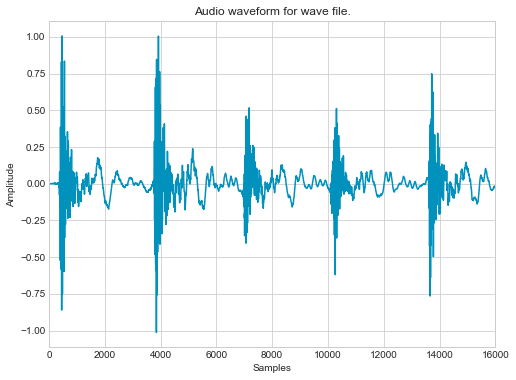

In [7]:
fig = plt.figure(figsize=(8,6))

plt.title("Audio waveform for wave file.")
plt.plot(audio_samples[:audio_sample_rate])
plt.xlabel("Samples")
plt.xlim(0, audio_sample_rate)
plt.ylabel("Amplitude")
plt.show()

Let's remove the first 300 samples due to silence at the start of the audio file and only keep 1 second of audio (16000 samples at 16kHz):

In [8]:
audio_samples = audio_samples[300:300 + audio_sample_rate]

### Windowing

Now we can split up the audio samples into overlapping windows. Typically a power of 2, such as 16, 32, 64, 128, 256, 512, 1024 or 2048 is selected as the window size. We'll use a window size of 256 and step over the audio signal 128 samples at the time. The following code can be used to illustrate the start and end of each window:

<!--
__new:__ I have rewrote this so windowing is mentioned before FFT.

The audio signal is first split into windows. When an FFT converts a signal from the time domain to the frequency domain, we lose the time information from the signal. Windowing the audio beforehand allows us to keep some time information as we know when each window occurs. You can move the window across the audio signal over time to capture how the frequencies in the audio signal change over time. Overlapping windows in the time domain helps create a more continuous frequency domain representation of the signal instead of a discrete one (as well as reducing artifacts at the boundary).

<br/>

Typically a power of 2, such as 16, 32, 64, 128, 256, 512, 1024 or 2048 is selected as the window size. We'll use a window size of 256 and step over the audio signal 128 samples at the time. The following code can be used to illustrate the start and end of each window:


__old__:

A Fast Fourier transforms (FFT) convert signals from the time domain to a frequency domain. This allows you determine the magnitude of the frequencies in the time domain for a specific period of time called a window. You can move the window across the audio signal over time to capture how the frequencies in the audio signal change over time. Overlapping windows in the time domain helps create a more continuous frequency domain representation of the signal instead of a discrete one (as well as reducing artifacts at the boundary).

<br/>

Typically a power of 2, such as 16, 32, 64, 128, 256, 512, 1024 or 2048 is selected as the window size. We'll use a window size of 256 and step over the audio signal 128 samples at the time. The following code can be used to illustrate the start and end of each window:
-->

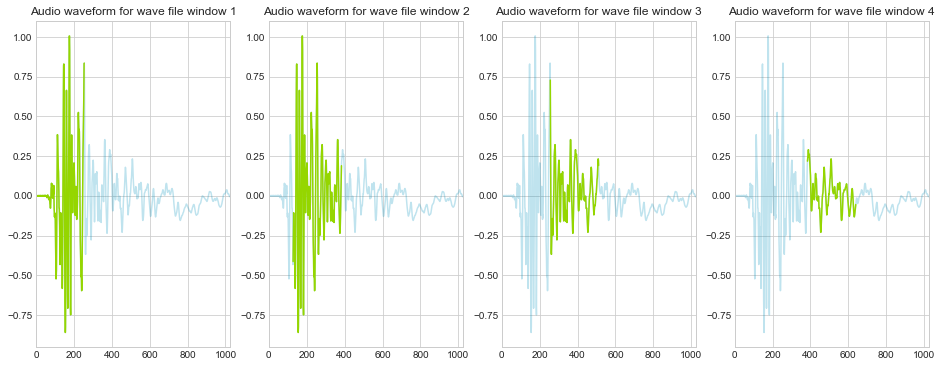

In [9]:
window_size = 256
step_size = 128

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 6))

for t in range(4):
    window_start = t * step_size
    window_end = window_start + window_size
    
    x_all = range(window_size * 4)
    y_all = audio_samples[:window_size * 4]
    
    x_window = range(window_start, window_end)
    y_window = audio_samples[window_start:window_end]

    axes[t].title.set_text(f"Audio waveform for wave file window {t + 1}")
    axes[t].plot(x_all, y_all, alpha=0.25)
    axes[t].plot(x_window, y_window)
    axes[t].set_xlim(0, len(y_all))

The current window is highlighted in green on top of the entire signal in blue. You can see the first window is from 0 to 256, the second window is from 128 to 384 (128 + 256), the third window is from 256 to 512, and the fourth window is from 384 to 640.

The total number of windows for the .wav file can be calculated as follows:

In [10]:
number_of_windows = (len(audio_samples) - window_size) // step_size

print(f"Total number of windows = {number_of_windows}")

Total number of windows = 123


### Window Functions and the Hanning Window

When processing continuous signals, like audio, a window function is applied before  applying the FFT transform, so that the edges of the slices of audio are smoother. A windowing function is a function which (usually) ranges from (0–1) and can be applied to a window as follows:

$$
𝑦 = 𝑤𝑖𝑛𝑑𝑜𝑤\_𝑓𝑢𝑛𝑐𝑡𝑖𝑜𝑛 × 𝑤𝑖𝑛𝑑𝑜𝑤
$$

One of the most common windowing functions (and the function used in this example) is the Hanning Window. [NumPy has a built-in method to calculate a Hanning Window](https://numpy.org/doc/stable/reference/generated/numpy.hanning.html) for any window length:

In [11]:
import numpy as np

hanning_window = np.hanning(window_size)

Let's plot out the Hanning Window using Matplotlib

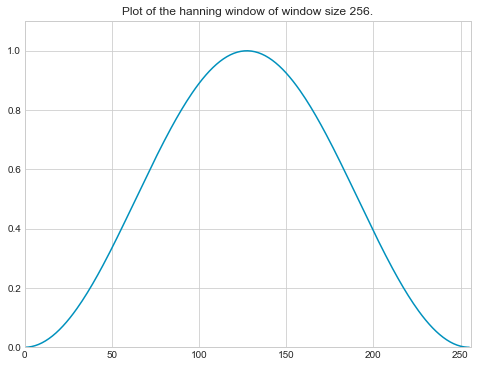

In [12]:
fig = plt.figure(figsize=(8,6))

plt.title(f"Plot of the hanning window of window size {window_size}.")
plt.plot(hanning_window)
plt.xlim([0, window_size])
plt.ylim([0, 1.1])
plt.show()

Now the Hanning Window can be applied to the first audio signal window using:

In [13]:
window_1 = audio_samples[0:window_size]

processed_window_1 = hanning_window * window_1

We can then plot the first window and processed window using Matplotlib

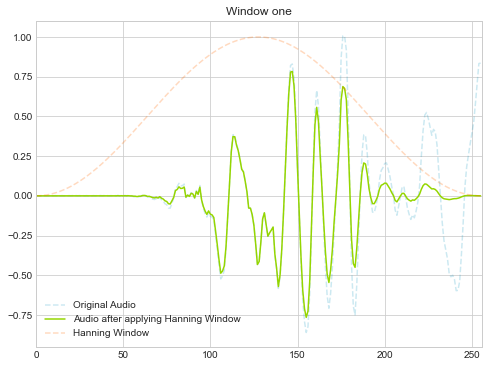

In [14]:
fig = plt.figure(figsize=(8,6))

plt.title(f"Window one")
plt.plot(window_1, "--", alpha=0.20, label = "Original Audio")
plt.plot(processed_window_1, label = "Audio after applying Hanning Window")
plt.plot(hanning_window, "--", alpha=0.25, label="Hanning Window")
plt.xlim([0, window_size])
plt.legend()
plt.show()

You can see the amplitude of the processed window never exceeds the value of the Hanning Window throughout the window period.

Let's extend our graph to loop through the first 4 windows.

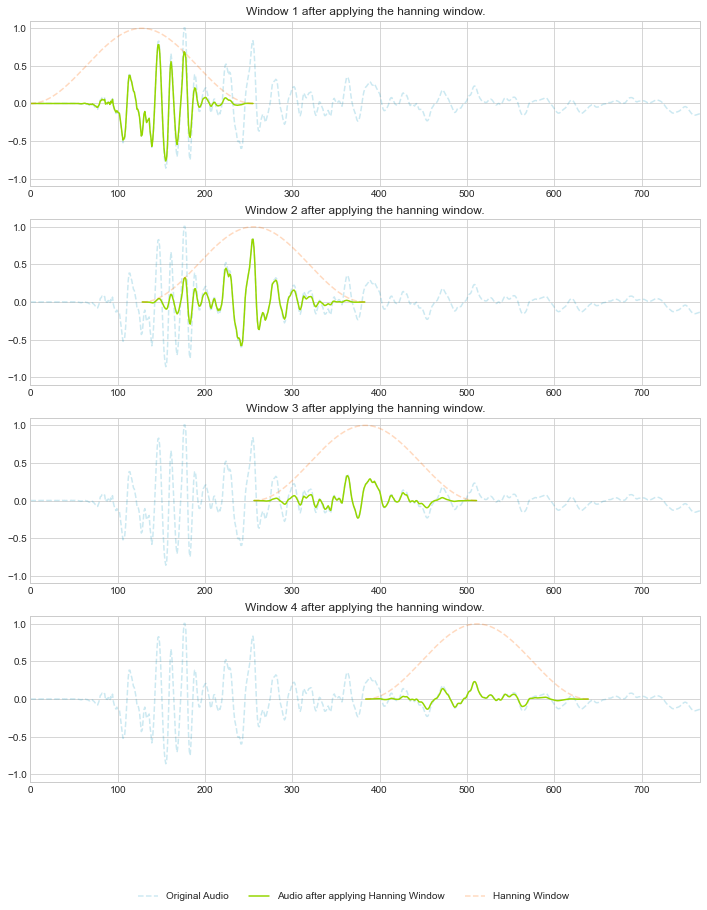

In [15]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 14))

for t in range(4):
    window_start = t * step_size
    window_end = window_start + window_size

    x_window = range(window_start, window_end)
    x_all = range(window_size * 3)
    
    window = audio_samples[window_start:window_end]
    processed_window = hanning_window * window
    
    ax = axes[t]
    
    ax.title.set_text(f"Window {t + 1} after applying the hanning window.")
    ax.plot(x_all, audio_samples[:window_size * 3], "--", alpha=0.20, label = "Original Audio")
    ax.plot(x_window, processed_window, label = "Audio after applying Hanning Window")
    ax.plot(x_window, hanning_window, "--", alpha=0.25, label="Hanning Window")
    ax.set_xlim([x_all[0], x_all[-1]])
    ax.set_ylim([-1.1, 1.1])

handles, labels = axes[0].get_legend_handles_labels()
_ = fig.legend(handles, labels, loc='lower center', ncol=3)


### FFT

For each processed window, the FFT can be calculated using NumPy's [`np.fft.rfft(...)`](https://numpy.org/doc/stable/reference/generated/numpy.fft.rfft.html) API and take the FFT's absolute value using [`np.absolute(...)`](https://numpy.org/doc/stable/reference/generated/numpy.absolute.html):

In [16]:
# Calculate the FFT.
fft_1 = np.fft.rfft(processed_window_1)

# Take the absolute value.
fft_bins_1 = np.absolute(fft_1)

We can then plot the FFT bins using Matplotlib.

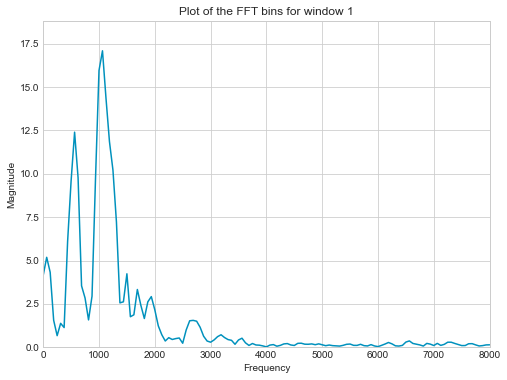

In [17]:
fig = plt.figure(figsize = (8,6))

# Calculate the frequencies of the FFT bins
xf = np.fft.rfftfreq(window_size, d=1./audio_sample_rate)

plt.plot(xf, fft_bins_1)
plt.xlabel("Frequency")
plt.xlim([xf[0], xf[-1]])
plt.ylabel("Magnitude")
plt.ylim([0, np.max(fft_bins_1) * 1.1])
_ = plt.title(f"Plot of the FFT bins for window 1")

Let's plot the FFT of the first 4 windows over time so we can see how the audio signal's frequency content changes over time:

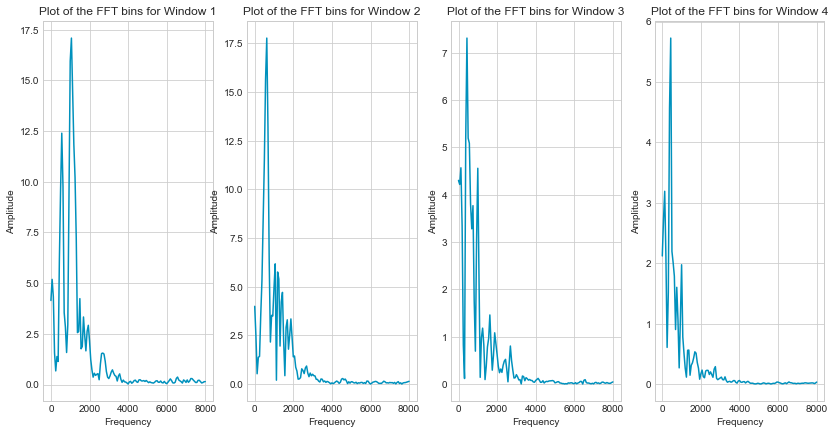

In [18]:
fig, axes = plt.subplots(1, 4, figsize=(14, 7))

for t in range(4):
    window_start = t * step_size
    window_end = window_start + window_size
    
    window = audio_samples[window_start:window_end]
    processed_window = hanning_window * window

    # Calculate the FFT.
    fft = np.fft.rfft(processed_window)

    # Take the absolute value.
    fft_bins = np.abs(fft)
    
    axes[t].plot(xf, fft_bins, alpha = 1)
    axes[t].set_title(f"Plot of the FFT bins for Window {t+1}")
    
    axes[t].set_xlabel("Frequency")
    axes[t].set_ylabel("Amplitude")

### Sprectrograms

Instead of having separate FFT graphs for each window period over time, we can create a single 2D graph of the audio signal frequency domain over time as a heatmap, also known as a spectrogram! This spectrogram shows time on the x-axis, frequency on the y-axis and finally amplitude with colour.

Let's loop through all the samples with an overlapping step and window size to calculate the signals frequency over time to display as a spectrogram. Here we calculate the number of windows in 1 second worth of audio.

In [19]:
# Putting this all together
window_size = 256
step_size = 128

# Calculate the number of windows
number_of_windows = int(1 + (audio_sample_rate - window_size) // step_size)

# Calculate the FFT Output size
num_fft_bins = int(window_size // 2 + 1)

# Create an empty array to hold the Spectrogram
spectrogram = np.empty((number_of_windows, num_fft_bins))

# Apply hanning window and apply fft
for index in range(number_of_windows):
    window_start = index * step_size
    window_end = window_start + window_size

    # Take the window from the waveform.
    window = audio_samples[window_start:window_end]

    # Apply the Hanning Window.
    processed_window = window * hanning_window

    # Calculate the FFT
    fft = np.fft.rfft(processed_window)

    # Take the absolute value of the FFT and add to the Spectrogram.
    spectrogram[index] = np.abs(fft)

Now that we've calculated the audio signal's spectrogram, let's plot it:

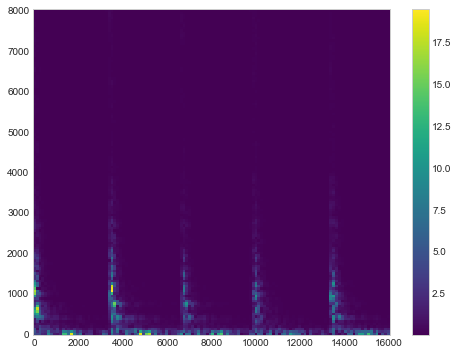

In [20]:
fig = plt.figure(figsize=(8,6))

height = spectrogram.T.shape[0]

X = np.arange(audio_sample_rate, step=height + 1)
Y = np.fft.rfftfreq(window_size, d=1./audio_sample_rate)

plt.pcolormesh(X, Y, spectrogram.T, cmap='viridis', shading='auto')
plt.colorbar()
plt.show()

From the spectrogram plot we can clearly see 5 areas of interest for each knock, with frequencies below 4000 Hz being more prevalent.

Let's zoom into the bottom half of the spectrogram and have a closer look:

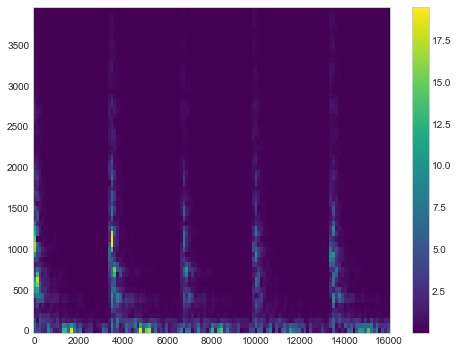

In [21]:
X = np.arange(audio_sample_rate, step=height + 1)
Y = np.fft.rfftfreq(window_size, d=1./audio_sample_rate)[:window_size // 4]

fig = plt.figure(figsize=(8,6))

plt.pcolormesh(X, Y, spectrogram.T[:window_size // 4,:], cmap='viridis', shading='auto')
plt.colorbar()
plt.show()

Let's have one more plot, but add the signal in the time domain above the spectrogram. Doing this, we can see the correlation between the signal's amplitude and frequency counts both against time.

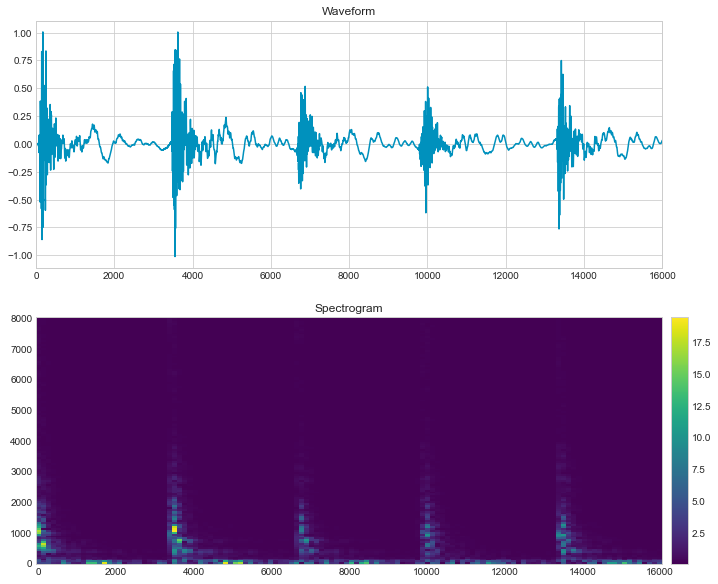

In [22]:
def plot_spectrogram(spectrogram, ax, fig= None):
    height = spectrogram.T.shape[0]
    X = np.arange(audio_sample_rate, step=height + 1)
    Y = np.fft.rfftfreq(window_size, d=1./audio_sample_rate)
    im = ax.pcolormesh(X, Y, spectrogram.T, cmap='viridis', shading='auto')

    return im

fig, axes = plt.subplots(2, figsize=(12, 10))

# Plot audio
timescale = np.arange(audio_samples.shape[0])
axes[0].plot(timescale, audio_samples)
axes[0].set_title('Waveform')
axes[0].set_xlim([0, audio_sample_rate])

# Shift for colorbar
fig.subplots_adjust(right=0.85)

# Get axes two coordinates
[[x10,y10],[x11,y11]] = axes[1].get_position().get_points()
pad = 0.01
width = 0.02

# Plot spectrogram and return colour map
im = plot_spectrogram(spectrogram, axes[1], fig)

# Add another axes next to colour bar
cbar_ax = fig.add_axes([x11+pad, y10, width, y11-y10])
axcb = fig.colorbar(im, cax=cbar_ax)

axes[1].set_title('Spectrogram')

plt.show()

display.display(display.Audio(audio_samples[:audio_sample_rate], rate=audio_sample_rate))

### Recap

Let's recap what we've accomplished so far:

1. Used the requests library to downloaded a .wav file of a door knocking sound from GitHub.
2. Used the SciPy library to read in the audio samples from a .wav file at 44.1 kHz and resampled them to have a 16 kHz sample rate.
3. Understood what windowing is and why it is needed along with a window functions like the Hanning Window.
4. Learned how to create an FFT of an audio signal over a specific window period.
4. Created a spectrogram representation of the audio signal by striding over the audio signal over time, applying a Hanning Window, and using the FFT function for each window period.

## Audio Spectrograms with CMSIS-DSP

Now that you understand how an audio spectrogram can be created using NumPy, we can do the same thing using the CMSIS-DSP Python Wrapper with fixed-point math.

### Introduction to fixed-point math and CMSIS-DSP

Unlike floating-point operations, fixed-point math numbers represent real number with less precision as they have a fixed number of bits to represent a number before and after the decimal point. For example, if we have 16-bit number in 1.15 fixed-point format, the 16-bit value can represent a value between -1 and 1, with a fixed precision of `1 / 2^15` = `0.000030517578125`.

Arm Cortex-M based processors are faster at integer based calculations than floating-point operations. Arm Cortex-M4, Cortex-M7, and latter processors include support of Single Instruction Multiple Data (SIMD) instructions, which allows them to perform the same instruction on multiple values at a time.

Arm's CMSIS-DSP library contains highly optimized implementations for common DSP operations for Arm Cortex-M processors.


### CMSIS-DSP Python Wrapper

Generally, you use the CMSIS-DSP library using C or C++ on the Arm Cortex-M device. However, the [CMSIS-DSP team has created a Python Wrapper](https://github.com/ARM-software/CMSIS_5/tree/develop/CMSIS/DSP/PythonWrapper) to leverage these DSP functions from with in Python.

<br/>

The library contains both highly optimized DSP function implementations for Arm Cortex-M processors and generic C implementations for non-Arm processors. If you are using the Arm CMSIS-DSP Python wrapper on your PC (which is likely x86 based), the functions will behave the same as they do on Arm processors from an input and output perspective, however you might not see and increase in runtime performance.

Let's go ahead and install the CMSIS-DSP Python Wrapper:

In [23]:
# TODO: change for RC once ready    
!pip install git+https://github.com/ARM-software/CMSIS_5.git@5.8.0-rc#egg=CMSISDSP\&subdirectory=CMSIS/DSP/PythonWrapper

  Cloning https://github.com/ARM-software/CMSIS_5.git (to revision 5.8.0-rc) to /private/var/folders/gn/lprz7cnx2fl9rvyytqz4bcy40000gn/T/pip-install-4q3mcbza/cmsisdsp
Using legacy 'setup.py install' for CMSISDSP, since package 'wheel' is not installed.
    Running setup.py install for CMSISDSP ... done
You should consider upgrading via the '/Users/sanmis01/Developer/git/fixed-point-dsp-for-data-scientists/.env/bin/python3 -m pip install --upgrade pip' command.


### Quantizing the input signal

We can use the [`arm_float_to_q15(...)`](https://arm-software.github.io/CMSIS_5/DSP/html/group__float__to__x.html#gac7696e64963e5051ebb950c88c6ba186) function from CMSIS-DSP to convert floating-point values to 16-bit fixed-point (Q15) values:

In [24]:
from cmsisdsp import arm_float_to_q15

audio_samples_q15 = arm_float_to_q15(audio_samples)

Now let's graph the fixed-point values along side the orignal NumPy values:

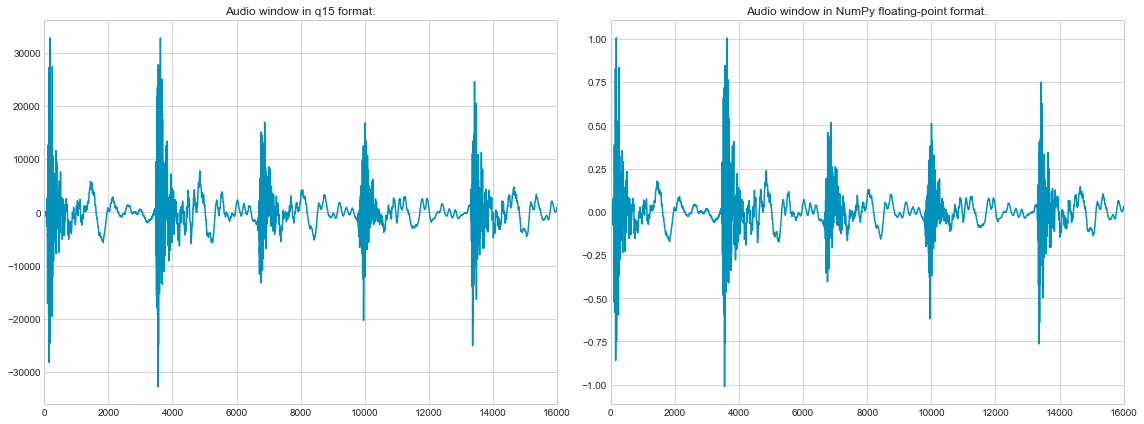

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

axes[0].plot(audio_samples_q15)
axes[0].set_title("Audio window in q15 format.")
axes[0].set_xlim([0, audio_sample_rate])

axes[1].plot(audio_samples)
axes[1].set_title("Audio window in NumPy floating-point format.")
axes[1].set_xlim([0, audio_sample_rate])

fig.tight_layout()

You can see the signal has a similiar shape to the one created with NumPy, however the values on the Y-axis range from -32768 to 32767 rather than 0 to 1.


### Hanning Window in CMSIS-DSP

CMSIS-DSP does not have a built-in function for creating a Hanning Window for a specific window size. However, we can levergage the built-in [`arm_cos_f32(...)`](https://arm-software.github.io/CMSIS_5/DSP/html/group__cos.html#gace15287f9c64b9b4084d1c797d4c49d8) and `arm_float_to_q15(...)` API's to create a fixed-point Hanning Window. Let's do this using the formula for the [Hann Function](https://en.wikipedia.org/wiki/Hann_function):

$$ f(x; window\_size) = \frac{1}{2} \left[ 1 - cos \left(\frac{2\pi x}{window\_size}\right) \right]$$

In [26]:
# Generate the Hanning Window
from numpy import pi as PI
from cmsisdsp import arm_cos_f32, arm_float_to_q15

hanning_window_f32 = np.zeros(window_size)

for i in range(window_size):
    hanning_window_f32[i] = 0.5 * (1 - arm_cos_f32(2 * PI * i / window_size ))
    

hanning_window_q15 = arm_float_to_q15(hanning_window_f32)

Now let's plot the Q15 Hanning Window along side the NumPy Hanning Window using Matplotlib:

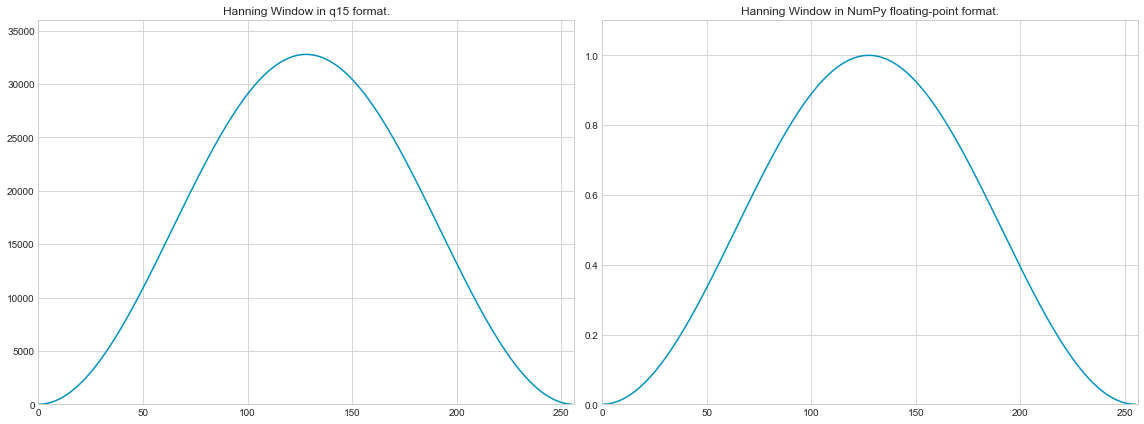

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

axes[0].plot(hanning_window_q15)
axes[0].set_title("Hanning Window in q15 format.")
axes[0].set_xlim([0, window_size])
axes[0].set_ylim([0, 32678 * 1.1])

axes[1].plot(hanning_window)
axes[1].set_title("Hanning Window in NumPy floating-point format.")
axes[1].set_xlim([0, window_size])
axes[1].set_ylim([0, 1.1])

fig.tight_layout()

You can see it has a similiar shape to the one created with NumPy, however the values range from 0 to 32767 rather than 0 to 1.

To apply the Hanning Window as we did in NumPy, we can use the [`arm_mult_q15(...)`](https://arm-software.github.io/CMSIS_5/DSP/html/group__BasicMult.html#gaeeda8cdc2c7e79c8a26e905342a0bb17) multiplication function to multiply two vectors of equal length together.

In [31]:
from cmsisdsp import arm_mult_q15

window_1_q15 = audio_samples_q15[:window_size]

# Multiply the signal by the window
processed_window_1_q15 = arm_mult_q15(window_1_q15, hanning_window_q15)

Lets now take a look at the first window after applying the Hanning Window in q15 format:

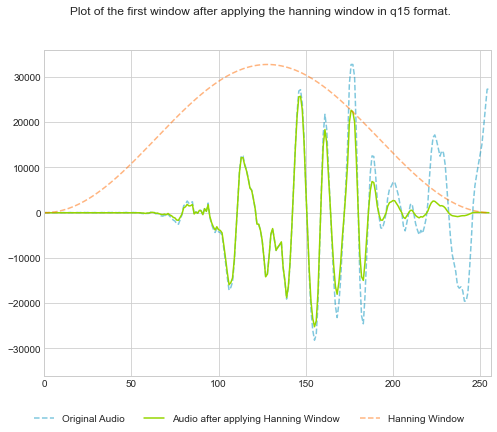

In [32]:
# Plot before and after Hanning Window

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
fig.suptitle("Plot of the first window after applying the hanning window in q15 format.")

axes.plot(window_1_q15, "--", alpha=0.5, label = "Original Audio")
axes.plot(processed_window_1_q15, label = "Audio after applying Hanning Window")
axes.plot(hanning_window_q15, "--", alpha=0.5, label="Hanning Window")

axes.set_xlim([0, window_size])
axes.set_ylim([-32767 * 1.1, 32767 * 1.1])

handles, labels = axes.get_legend_handles_labels()
_ = fig.legend(handles, labels, loc='lower center', ncol=3)

Let's graph it side by side with the NumPy values:

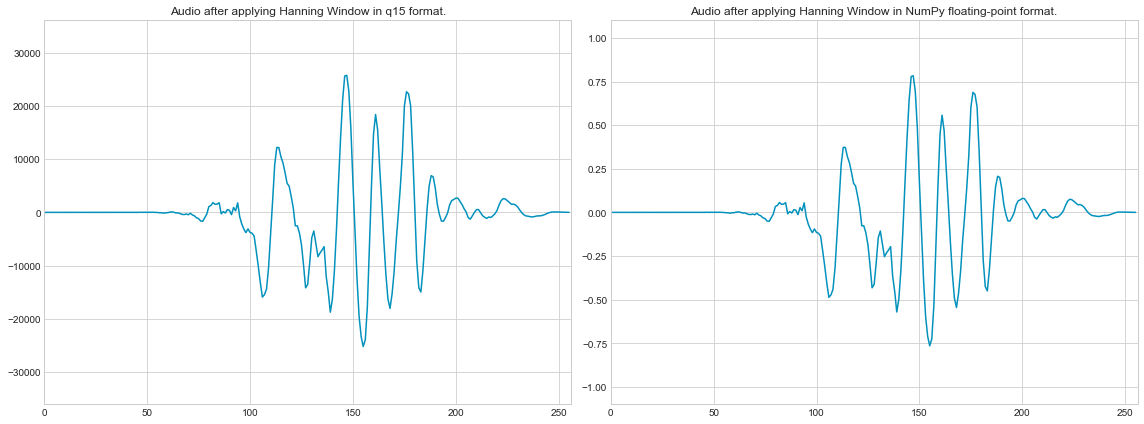

In [33]:
# Plot q15 vs NumPy

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

axes[0].plot(processed_window_1_q15) 
axes[0].set_title("Audio after applying Hanning Window in q15 format.")
axes[1].plot(processed_window_1)
axes[1].set_title("Audio after applying Hanning Window in NumPy floating-point format.")

axes[0].set_xlim([0, window_size])
axes[1].set_xlim([0, window_size])
axes[0].set_ylim([-32767 * 1.1, 32767 * 1.1])
axes[1].set_ylim([-1 * 1.1, 1 * 1.1])

fig.tight_layout()

### FFT with CMSIS-DSP

[CMSIS-DSP provides many FFT functions](https://arm-software.github.io/CMSIS_5/DSP/html/group__groupTransforms.html) for various data types: q15, q31 and f32. In this example, we will be using [the Real FFT functions](https://arm-software.github.io/CMSIS_5/DSP/html/group__RealFFT.html). To use CMSIS-DSP's Q15 RFFT function, we first need to create an [`arm_rfft_instance_q15`](https://arm-software.github.io/CMSIS_5/DSP/html/structarm__rfft__instance__q15.html) instance and initialize it with the [`arm_rfft_init_q15(...)`](https://arm-software.github.io/CMSIS_5/DSP/html/group__RealFFT.html#ga053450cc600a55410ba5b5605e96245d) function. After that, the process is similar to NumPy, you can use the [`arm_rfft_q15(...)`](https://arm-software.github.io/CMSIS_5/DSP/html/group__RealFFT.html#ga00e615f5db21736ad5b27fb6146f3fc5) function to calculate the FFT and [`arm_cmplx_mag_q15(...)`](https://arm-software.github.io/CMSIS_5/DSP/html/group__cmplx__mag.html#ga0488e185f4631ac029b02f1759b287cf) to calculate the magitude of the FFT.

In [34]:
from cmsisdsp import arm_rfft_instance_q15, arm_rfft_init_q15, arm_rfft_q15, arm_cmplx_mag_q15

# Initialize the FFT
rfft_instance_q15 = arm_rfft_instance_q15()
status = arm_rfft_init_q15(rfft_instance_q15, window_size, 0, 1)

# Apply the FFT to the audio
rfft_1_q15 = arm_rfft_q15(rfft_instance_q15, processed_window_1_q15)

# Take the absolute value
fft_bins_1_q15 = arm_cmplx_mag_q15(rfft_1_q15)[:window_size // 2 + 1]

xf = np.fft.rfftfreq(len(processed_window_1_q15), d=1./audio_sample_rate)

We can now graph the Q15 fixed-point values with Matplotlib:

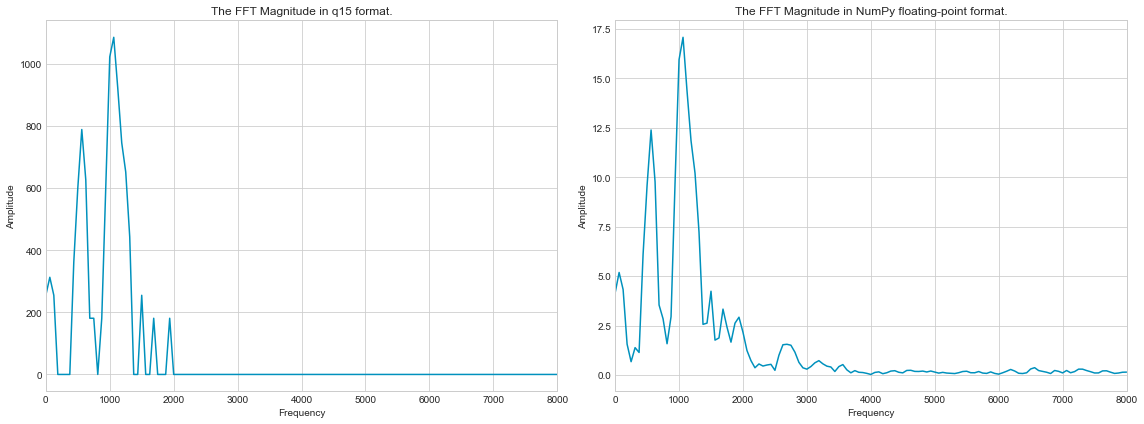

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

axes[0].plot(xf, fft_bins_1_q15)
axes[0].set_xlabel("Frequency")
axes[0].set_xlim([xf[0], xf[-1]])
axes[0].set_ylabel("Amplitude")
axes[0].set_title("The FFT Magnitude in q15 format.")

axes[1].plot(xf, fft_bins_1)
axes[1].set_xlabel("Frequency")
axes[1].set_xlim([xf[0], xf[-1]])
axes[1].set_ylabel("Amplitude")
axes[1].set_title("The FFT Magnitude in NumPy floating-point format.")

fig.tight_layout()

Now let's convert the `fft_bins_1_q15` Q15 values to be be floating-point value, so we can compare the value with the NumPy calculated value.

The output format of the `arm_rfft_q15(...)` function when an RFFT length of 256 is used, will be `9.7` (instead of `1.15`). The documentation for the [`arm_cmplx_mag_q15(...)`](https://arm-software.github.io/CMSIS_5/DSP/html/group__cmplx__mag.html#ga0488e185f4631ac029b02f1759b287cf) function explains input values are in `1.15` format and outputs will be in `2.14` format. So, if we pass an `9.7` format number into `arm_cmplx_mag_q15(...)`, the output will have a format of `10.6` - which mean's it's value will range from `-512` to `511`.

We can convert the `10.6` number into a floating point value by converting it from a Q15 to a float using the [`arm_q15_to_float(...)`](https://arm-software.github.io/CMSIS_5/DSP/html/group__q15__to__x.html#ga5a75381e7d63ea3a3a315344615281cf) function and multiplying it by `512` (`2^9`):

In [36]:
from cmsisdsp import arm_q15_to_float

# Let's rescale them and compare the two
fft_bins_1_q15_scaled = arm_q15_to_float(fft_bins_1_q15) * 512

We can overlay them to see how close they are:

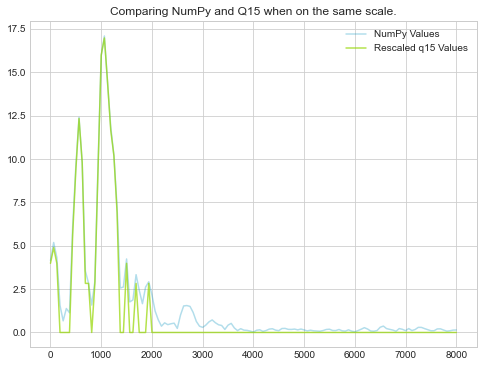

In [37]:
fig = plt.figure(figsize = (8,6))

plt.plot(xf, fft_bins_1, label = "NumPy Values", alpha = 0.3)
plt.plot(xf, fft_bins_1_q15_scaled, label = "Rescaled q15 Values", alpha = 0.7)
plt.title("Comparing NumPy and Q15 when on the same scale.")
plt.legend()
plt.show()

As we can see from above, the two pipelines produce very visually similar features.

Although some information is lost using fixed-point functions, we managed to calculate a similar shape and show peaks at the same frequencies. The frequencies that the fixed-point functions did not manage to calculate (to the right of 2000), all have a really low amplitude showing the information lost is minimal.

### Spectrogram with CMSIS-DSP

Finally, we need to put all this together as we did with NumPy.

In [38]:
# Putting this all together
window_size = 256
step_size = 128

# Convert the audio to q15
audio_samples_q15 = arm_float_to_q15(audio_samples)

# Calculate the number of windows
number_of_windows = int(1 + (audio_sample_rate - window_size) // step_size)

# Calculate the FFT Output size
fft_size = int(window_size // 2 + 1)

# Create an empty array to hold the Spectrogram
spectrogram_q15 = np.empty((number_of_windows, fft_size))

start_index = 0
# Apply hanning window and apply fft
for index in range(number_of_windows):
    # Take the window from the waveform.
    audio_window_q15 = audio_samples_q15[start_index:start_index + window_size]
    
    # Apply the Hanning Window.
    processed_audio_q15 = arm_mult_q15(audio_window_q15, hanning_window_q15)
    
    # Calculate the FFT
    rfft_q15 = arm_rfft_q15(rfft_instance_q15, processed_audio_q15)
    
    # Take the absolute value of the FFT and add to the Spectrogram.
    rfft_mag_q15 = arm_cmplx_mag_q15(rfft_q15)[:fft_size]
    
    spectrogram_q15[index] = rfft_mag_q15
    
    # Increase the start index of the window by the overlap amount.
    start_index += step_size

Now let's graph the both the input signal and Q15 Spectrogram with Matplotlib:

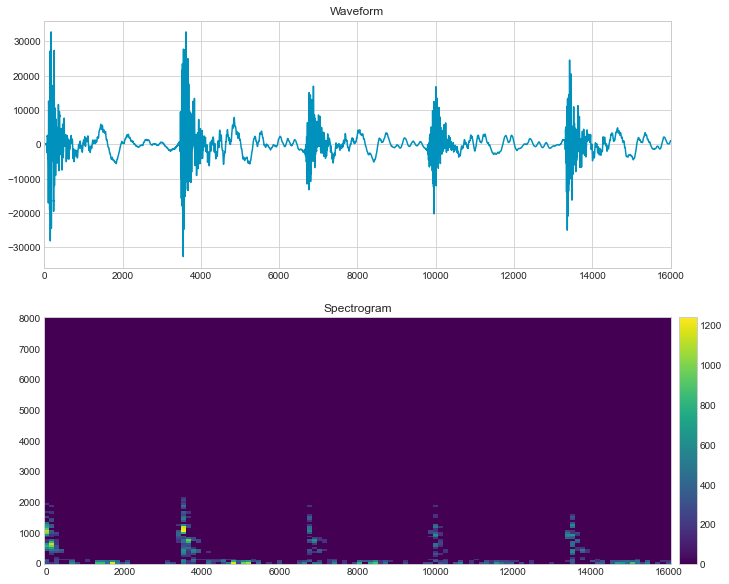

In [39]:
fig, axes = plt.subplots(2, figsize=(12, 10))

timescale = np.arange(audio_samples_q15.shape[0])

axes[0].plot(timescale, audio_samples_q15)
axes[0].set_title('Waveform')
axes[0].set_xlim([0, audio_sample_rate])

# Shift for colorbar
fig.subplots_adjust(right=0.85)

# Get axes two coordinates
[[x10,y10],[x11,y11]] = axes[1].get_position().get_points()
pad = 0.01
width = 0.02

im = plot_spectrogram(spectrogram_q15, axes[1], fig)

# Add another axes next to colour bar
cbar_ax = fig.add_axes([x11+pad, y10, width, y11-y10])
axcb = fig.colorbar(im, cax=cbar_ax)

_ = axes[1].set_title('Spectrogram')

And finally compare Q15 spectrogram with the NumPy version:

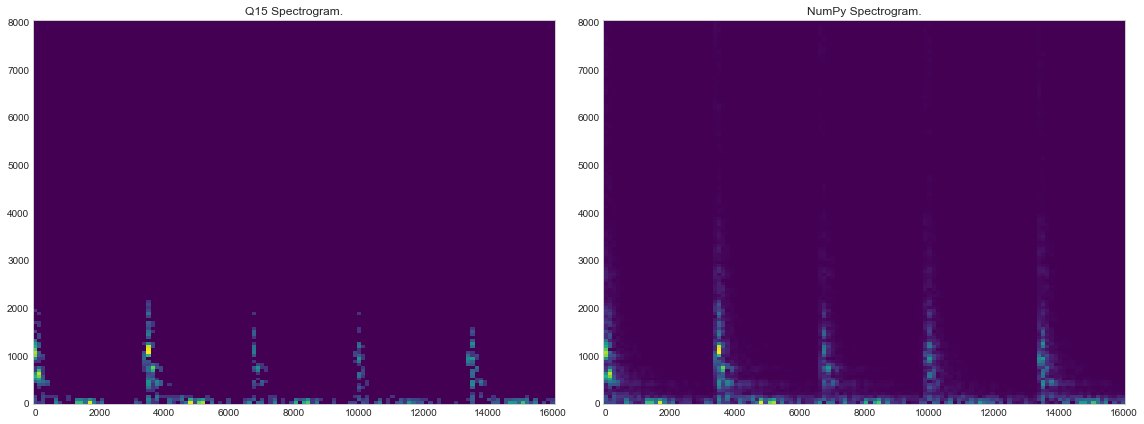

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
plot_spectrogram(spectrogram_q15, axes[0], fig)
axes[0].set_title("Q15 Spectrogram.")

plot_spectrogram(spectrogram, axes[1], fig)
axes[1].set_title("NumPy Spectrogram.")
fig.tight_layout()

### Recap

As we have seen, the CMSIS-DSP pipeline is similar to the NumPy pipeline. Let's recap the what we've done to create it:

1. Converted the audio samples into Q15 format using the `arm_float_to_q15` function.
2. Calculated the Hanning Window using the Hann Function formula using the `arm_cos_f32` and `arm_float_to_q15` functions.
3. Learned how to multiply to vectors of the same length using the `arm_mult_q15` function.
4. Learned how to calculate a Q15 FFT in CMSIS-DSP using the `arm_rfft_instance_q15`, `arm_rfft_init_q15`, and `arm_rfft_q15` functions.
5. Created a spectrogram representation of the audio signal by striding over the audio signal over time, applying a Hanning Window, and using the FFT function for each window period.

## Spectrogram examples for different audio sounds

Let's now take a look at a few different spectrograms for different audio files in the [ESC-50 repository](https://github.com/karolpiczak/ESC-50). To do this, we have converted the pipeline into a function.

In [41]:
def calculate_q15_spectrogram(audio_samples, rfft_instance_q15, window_size=256, step_size=128):
    
    # Convert the audio to q15
    audio_samples_q15 = arm_float_to_q15(audio_samples)

    # Calculate the number of windows
    number_of_windows = int(1 + (audio_sample_rate - window_size) // step_size)

    # Calculate the FFT Output size
    num_fft_bins = int(window_size // 2 + 1)

    # Create an empty array to hold the Spectrogram
    spectrogram_q15 = np.empty((number_of_windows, num_fft_bins))

    start_index = 0
    # Apply hanning window and apply fft
    for index in range(number_of_windows):
        # Take the window from the waveform.
        audio_window_q15 = audio_samples_q15[start_index:start_index + window_size]
    
        # Apply the Hanning Window.
        processed_audio_q15 = arm_mult_q15(audio_window_q15, hanning_window_q15)
    
        # Calculate the FFT
        rfft_q15 = arm_rfft_q15(rfft_instance_q15, processed_audio_q15)
    
        # Take the absolute value of the FFT and add to the Spectrogram.
        rfft_mag_q15 = arm_cmplx_mag_q15(rfft_q15)[:fft_size]
        
        spectrogram_q15[index] = rfft_mag_q15
    
        # Increase the start index of the window by the overlap amount.
        start_index += step_size    
    
    return spectrogram_q15

We can now download some examples and plot the spectrogram for each one:

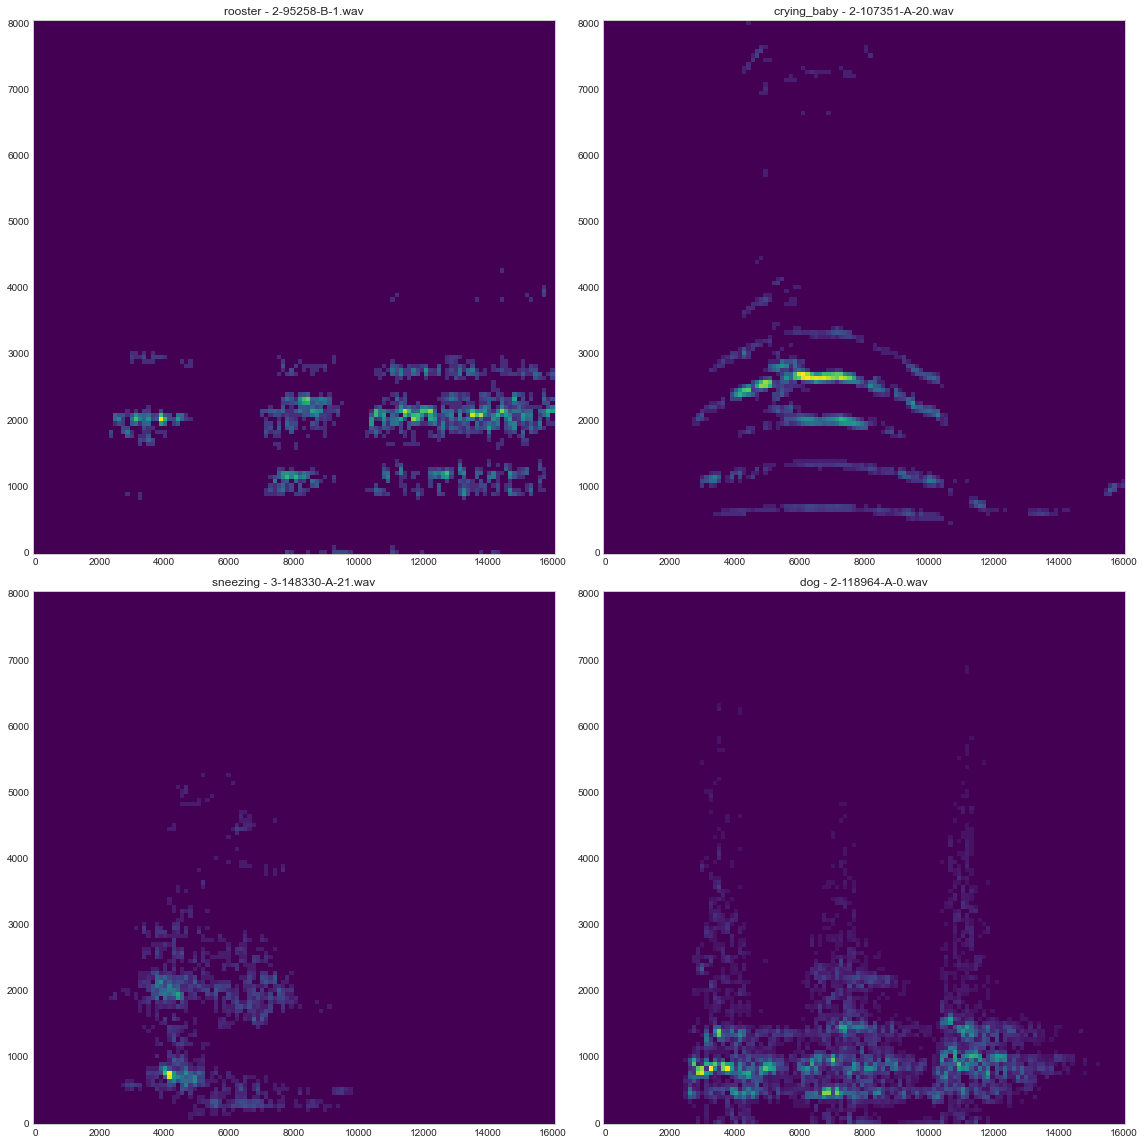

In [42]:
#Example audio files and label.
examples = [("rooster", "2-95258-B-1.wav"), ("crying_baby", "2-107351-A-20.wav"), 
           ("sneezing", "3-148330-A-21.wav"), ("dog","2-118964-A-0.wav")]

# Set size of plots
rows, cols = (2, 2)
n = rows * cols
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(16, 16))

for i in range(4):
    # calculate row and col index
    r = i // rows
    c = i % cols
    
    # Take example from examples
    example = examples[i]
    title = example[0]
    filename = example[1]
    
    #Download the example
    response = requests.get(f"https://raw.githubusercontent.com/karolpiczak/ESC-50/master/audio/{filename}")
    with open(filename, "wb") as f:
        f.write(response.content)
    
    # Read audio samples
    audio_samples = read_wave_file(filename, audio_sample_rate)
    
    #calculate spectrogram
    spectrogram_q15 = calculate_q15_spectrogram(audio_samples, rfft_instance_q15, 256, 128)
    
    # plot spectrogram
    ax = axes[r][c]
    plot_spectrogram(spectrogram_q15, ax, fig)
    ax.set_title(f"{title} - {filename}")
    
    
fig.tight_layout()

## Porting CMSIS-DSP code from Python to C

Now that we have a general understanding of how to use the various CMSIS-DSP API's in Python from the last section, we can start to map these to C to run on our Cortex-M based system.


### Includes

The first step will be to add an `#include <arm_math.h>` to the top of your `.c` file:

```c
#include <arm_math.h>
```

### Constants

Then we can define some constant variables for the window and step size:


```c
const int WINDOW_SIZE = 256;
const int STEP_SIZE   = 128;
```

### Input Signal

A global array variable can be declared to store the input signal:

```c
q15_t input_q15[WINDOW_SIZE];
```

The input signal to create the spectrum for can be stored in the `input_q15` variable.

For testing purposes, we'll set it to be a fixed sine wave with a frequency of 440 Hz sampled at 16 kHz.

```c
for (int i = 0; i < WINDOW_SIZE; i++) {
    float32_t f = sin((2 * PI * 440) / 16000 * i);
    
    arm_float_to_q15(&f, &input_q15[i], 1);
}
```

### Hanning Windows

For the Hanning Window function you must declare a global array variable to store the window function values:


```c
q15_t hanning_window_q15[WINDOW_SIZE];

```

Then we can create a C function that initializes the `hanning_window_q15` array at runtime:

```c
void hanning_window_init_q15(q15_t* hanning_window_q15, size_t size) {
    for (size_t i = 0; i < size; i++) {
        // calculate the Hanning Window value for i as a float32_t
        float32_t f = 0.5 * (1.0 - arm_cos_f32(2 * PI * i / size ));
        
        // convert value for index i from float32_t to q15_t and store
        // in window at position i
        arm_float_to_q15(&f, &hanning_window_q15[i], 1);
    }
}
```

We will need another variable to store the value of the applied Hanning Window on the Input Signal:

```c
q15_t processed_window_q15[WINDOW_SIZE];
```

Now we can apply the Hanning Window on the Input Signal:

```c
// equivalent to: processed_window_q15 = input_q15 * hanning_window_q15
arm_mult_q15(input_q15, hanning_window_q15, processed_window_q15, WINDOW_SIZE);
```

### FFT

### Variables

We'll need global variables for the FFT instance and outputs:


```c
arm_rfft_instance_q15 S_q15;

// this is twice the size because each FFT output has a real and imaginary part
q15_t fft_q15[WINDOW_SIZE * 2];

// this is half the size of WINDOW_SIZE becase we just need the magnitude from
// the first half of the FFT output
q15_t fft_mag_q15[WINDOW_SIZE / 2];

```

### Initialization

We need to call `arm_rfft_init_q15` to initialize the Q15 RFFT instance:

```c
arm_rfft_init_q15(&S_q15, WINDOW_SIZE, 0, 1);
```

### Performing the FFT

Performing the FFT and calculating the FFT's outputs magnitude can now be done with:

```c
arm_rfft_q15(&S_q15, processed_window_q15, fft_q15);

arm_cmplx_mag_q15(fft_q15, fft_mag_q15, WINDOW_SIZE / 2);

```


### Tying Everything Together as an Arduino Sketch


```c

#include <arm_math.h>

// constants
const int WINDOW_SIZE = 256;
const int STEP_SIZE   = 128;

// global variables
q15_t input_q15[WINDOW_SIZE];
q15_t hanning_window_q15[WINDOW_SIZE];
q15_t processed_window_q15[WINDOW_SIZE];

arm_rfft_instance_q15 S_q15;

// this is twice the size because each FFT output has a real and imaginary part
q15_t fft_q15[WINDOW_SIZE * 2];

// this is half the size of WINDOW_SIZE becase we just need the magnitude from
// the first half of the FFT output
q15_t fft_mag_q15[WINDOW_SIZE / 2];


void setup() {
  Serial.begin(9600);
  while (!Serial);

  Serial.println("Hello from CMSIS DSP Q15 FFT example");
  
  // initialize input with a 400 Hz sine wave
  for (int i = 0; i < WINDOW_SIZE; i++) {
    float32_t f = sin((2 * PI * 440) / 16000 * i);
    
    arm_float_to_q15(&f, &input_q15[i], 1);
  }

  // pipeline initialization
  hanning_window_init_q15(hanning_window_q15, WINDOW_SIZE);
  arm_rfft_init_q15(&S_q15, WINDOW_SIZE, 0, 1);
}

void loop() {
  unsigned long pipeline_start_us = micros();
  
  // equivalent to: processed_window_q15 = input_q15 * hanning_window_q15
  arm_mult_q15(input_q15, hanning_window_q15, processed_window_q15, WINDOW_SIZE);

  // calculate the FFT and FFT magnitude
  arm_rfft_q15(&S_q15, processed_window_q15, fft_q15);
  arm_cmplx_mag_q15(fft_q15, fft_mag_q15, WINDOW_SIZE / 2);

  unsigned long pipeline_end_us = micros();

  Serial.print("Pipeline run time = ");
  Serial.print(pipeline_end_us - pipeline_start_us);
  Serial.println(" microseconds");


  // all done loop forever ...
  while (1);
}


void hanning_window_init_q15(q15_t* hanning_window_q15, size_t size) {
  for (size_t i = 0; i < size; i++) {
    // calculate the Hanning Window value for i as a float32_t
    float32_t f = 0.5 * (1.0 - arm_cos_f32(2 * PI * i / size ));

    // convert value for index i from float32_t to q15_t and store
    // in window at position i
    arm_float_to_q15(&f, &hanning_window_q15[i], 1);
  }
}
```

### Performance Benchmarks

Now let's benchmark the Arduino sketch from above on the following Arduino or Arduino compatible boards:
 * [Arduino Nano 33 IoT](https://store.arduino.cc/usa/nano-33-iot)
 * [Arduino Nano 33 BLE](https://store.arduino.cc/usa/nano-33-ble)
 * [Teensy 4.0](https://www.pjrc.com/store/teensy40.html)
 
 
We've created an equivalent sketch for that uses 32-bit floating-point instead of fixed-point as a comparison against our fixed-point sketch above. Both sketches can be found on GitHub:
 * [cmsis_dsp_fft_q15.ino](https://github.com/sandeepmistry/fixed-point-dsp-for-data-scientists/blob/main/cmsis_dsp_fft_q15/cmsis_dsp_fft_q15.ino)
 * [cmsis_dsp_fft_f32.ino](https://github.com/sandeepmistry/fixed-point-dsp-for-data-scientists/blob/main/cmsis_dsp_fft_f32/cmsis_dsp_fft_f32.ino)

 
#### RAM Usage

We should expect to see the buffers we need for the DSP operations to take half as much space when we use 16-bit Q15 instead of 32-bit floating-point.

Our current buffers include:

| Buffer Name | Number of Elements | Size in bytes F32 | Size in bytes Q15 |
| ----------- | ------------------ | ----------------- | ------------------|
| `input` | `WINDOW_SIZE` | 4 * `WINDOW_SIZE` | 2 * `WINDOW_SIZE` |
| `hanning_window` | `WINDOW_SIZE` | 4 * `WINDOW_SIZE` | 2 * `WINDOW_SIZE` |
| `processed_window` | `WINDOW_SIZE` | 4 * `WINDOW_SIZE` | 2 * `WINDOW_SIZE` |
| `fft` | 2 * `WINDOW_SIZE` | 2 * 4 * `WINDOW_SIZE` | 2 * 2 * `WINDOW_SIZE` |
| `fft_mag` | `WINDOW_SIZE` / 2 | 4 * `WINDOW_SIZE` / 2 | 2 * `WINDOW_SIZE` / 2|
| | | | |
| TOTAL | 4.5 * `WINDOW_SIZE` | 22 * `WINDOW_SIZE` | 11 * `WINDOW_SIZE` |


So with a `WINDOW_SIZE = 256` we expect:

 * F32: 22 * 256 = 5632 bytes
 * Q15: 11 * 256 = 2816 bytes
 
This illustrates that using fixed-point with Q15 requires half the RAM that using F32.

If we compile our sketches we get the following metrics for "Global variables use".

| Board | f32 RAM used | q15 RAM used | Difference |
| ----- | ------------ | ------------ | ---------- |
| Arduino Nano 33 IoT (Cortex-M0+ @ 48 MHz) | 8044 bytes | 5224 bytes | **2820 bytes** |
| Arduino Nano 33 BLE (Cortex-M4F @ 64 MHz) |  49576 bytes | 46760 bytes | **2816 bytes** |
| Teensy 4.0 (Cortex-M7F @ 600 MHz) | 131772 bytes| 119484 bytes| **12288 bytes** |

The values from our Arduino match exactly to the amount of RAM we expected to save.

#### Run-time speed

Now let's upload both benchmarking sketches to the boards to see how long it takes to calculate the FFT bins for a single input window:


| Board | f32 time | q15 time | Difference | Improvement Percentage |
| ----- | -------- | -------- | ---------- | ---------------------- |
| Arduino Nano 33 IoT (Cortex-M0+ @ 48 MHz) | 21784 us | 1720 us | **20064 us** | 1166.51 % (11.66x faster) |
| Arduino Nano 33 BLE (Cortex-M4F @ 64 MHz) | 541 us |  393 us | **148 us** | 37.67 % |
| Teensy 4.0 (Cortex-M7F @ 600 MHz) | 24 us |  19 us | **5 us** | 26.32 % |

The Arduino Nano 33 IoT board which is based on an Arm Cortex-M0+ CPU and is not equipped with a FPU (Floating Point Unit) has completes the pipline 11 times faster using the 16-bit fixed-point DSP pipeline instead of the 32-bit floating-point version. The Arduino Nano 33 BLE which is based on an Arm Cortex-M4F CPU and equipped with a FPU has a improvement of 37%. Finally, the Teensy 4.0 which is based on an Arm Cortex-M7 CPU which is equipped with a FPU has a improvement of 26%.

## Conclusion

This guide has given an overview of a DSP pipeline to convert an audio signal into a spectrogram, which can then be combined with computer vision techniques to classify audio signals. We've explained what a spectrogram is and how to create one from a .wav file in Python and NumPy using the following DSP operatons: Windowing, the Hanning Window and FFT's. After this, you've learned about fixed-point math and how the CMSIS-DSP Python Wrapper can be used to create an equivalent spectrogram using 16-bit fixed-point operations with minimal loss in accuracy. We then covered how to port the CMSIS-DSP pipeline from Python to C to run on an Arm Cortex-M based device.

In our benchmarks, the global buffers required by the DSP pipeline required 50% less memory when using fixed-point 16-bit operations instead of 32-bit floating-point operations. The Cortex-M0+ (with no FPU) had a 11x speed increase when using fixed-point 16-bit operations instead of floating-point. The Cortex-M4F and Cortex-M7F systems with built-in FPU's saw a 37% and 26% increase in speed when using fixed-point 16-bit operations instead of floating-point, these are impressive improvements. Using fixed-point also saves a conversion step, audio input values are (often) stored as 16-bit values when they are read from analog microphones (using an ADC) or digital microphones.


For more blogs, guides, resources, videos and notebooks from the [Arm Software Developer's team](https://developer.arm.com) please visit:
 - [@ArmSoftwareDev on Twitter](https://twitter.com/ArmSoftwareDev)
 - [The Arm Software Developers YouTube channel](https://www.youtube.com/c/ArmSoftwareDevelopers)

### DSP Pipeline - Code Cheat Sheet - Comparison Table

We've created a summary of the various DSP steps used in pipeline using NumPy and CSMIS-DSP in both Python and C:

|   | **NumPy** Python | **CMSIS-DSP** Python | **CMSIS-DSP** C |
| - | ---------------- | -------------------- | --------------- |
| **Import / Include** | `import numpy as np`| `from cmsisdsp import arm_cos_f32, arm_rfft_instance_q15, arm_rfft_init_q15, arm_mult_q15, arm_rfft_q15, arm_cmplx_mag_q15` | `#include <arm_math.h>` |
| **Hanning Window initialization** |`hanning_window = np.hanning(window_size)` | <code>hanning_window_f32 = np.zeros(window_size)<br/><br/>for i in range(window_size):<br/>&nbsp;&nbsp;hanning_window_f32[i] = 0.5 * (1 - arm_cos_f32(2 * PI * i / window_size ))<br/><br/>hanning_window_q15 = arm_float_to_q15(hanning_window_f32)</code> | <code>for (size_t i = 0; i < size; i++) {<br/>&nbsp;&nbsp;float32_t f = 0.5 * (1.0 - arm_cos_f32(2 * PI * i / size ));<br/>&nbsp;&nbsp;arm_float_to_q15(&f, &hanning_window_q15[i], 1);<br/>}</code> |
| **FFT Initialization** | N/A | <code>rfft_instance_q15 = arm_rfft_instance_q15()<br/>arm_rfft_init_q15(rfft_instance_q15, window_size, 0, 1)</code> | `arm_rfft_init_q15(&S_q15, WINDOW_SIZE, 0, 1);` |
| **Hanning Window applying** |`processed_window = hanning_window * window` | `processed_window_q15 = arm_mult_q15(window_q15, hanning_window_q15)` | `arm_mult_q15(input_q15, hanning_window_q15, processed_window_q15, WINDOW_SIZE);` |
| **FFT** | `fft = np.fft.rfft(processed_window)` | `rfft_q15 = arm_rfft_q15(rfft_instance_q15, processed_audio)` | `arm_rfft_q15(&S_q15, processed_window_q15, fft_q15);` |
| **FFT Magnitude** | `fft_bins = np.abs(fft)` | `fft_bins_q15 = arm_cmplx_mag_q15(rfft_q15)[:window_size // 2 + 1]` | `arm_cmplx_mag_q15(fft_q15, fft_mag_q15, WINDOW_SIZE / 2);` |

Remember when using CMSIS-DSP in C you are responsible for allocating your own buffers to store the output values from CMSIS-DSP API's.

